In [1]:
# imports
from utils import *

2025-03-13 16:52:20.698809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741881140.716870   46844 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741881140.721844   46844 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741881140.734655   46844 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741881140.734669   46844 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1741881140.734670   46844 computation_placer.cc:177] computation placer alr

In [2]:
# read the configuration file and initialize random generators
cfg = read_config('configfiles/config.yaml')
seeds = read_config('configfiles/seed_config.yaml')
initalize_random_generators(seeds)

# Data loading and processing

In [3]:
categories = ["Toilet","Shower","Faucet","ClothesWasher","Dishwasher","Bathtub"]
def map_to_category(y: int, categories: list):
    y = int(y)
    return categories[y-1]

allData = pd.read_csv(cfg['dataset'])

In [5]:
test_values = pd.Series([1, 2, 3, 4, 5, 6], dtype='int64')
mapped_values = test_values.map(lambda x: map_to_category(x, categories))
print(mapped_values)

0           Toilet
1           Shower
2           Faucet
3    ClothesWasher
4       Dishwasher
5          Bathtub
dtype: object


In [6]:
# process dataset (separate features & classes, split in train and test, reduce train size if needed)
X_cv, X_test, y_cv, y_test = data_prep(allData, cfg['features'], cfg['target'],
                                       randomState=seeds['dprep_seed'], 
                                       testSize=cfg['frac_tst'], 
                                       trainSize=cfg['train_size'])

In [7]:
# create folds using smoter (created beforehand to speed-up computation)
# smoter = SMOTE(random_state=seeds['smote_seed'], sampling_strategy='auto', 
#                k_neighbors = cfg['smote_kneighbors'], n_jobs = -1)
folds = create_folds_with_SMOTE(X_cv, y_cv, n_splits=cfg['n-folds'], smoter=None)

# Model training and testing

In [ ]:
# find best parameters for each algorithm via cross-validation
# run for 10 different starting seeds
for i in range(1):
    print('Start hyperparameter search for seed ' + str(i))
    initalize_random_generators(seeds, i)
    # find best parameters for each algorithm via cross-validation
    results = cv_model_selection(folds, cfg, i)
    # save results
    results.to_pickle(cfg['cvResultsDir']+'/cv_results_seed{}'.format(i))


In [3]:
# select best params combination for each algorithm
best_models, performance_distr = best_model_selection(cfg, [1,1,1,1])

In [4]:
best_models

,algorithm,params,median_f1score,time
0,LGBMClassifier,"{'device': 'cpu', 'learning_rate': 0.08, 'max_...",0.977148,68.508504


In [5]:
best_models.to_pickle('best_models_wo_smote')


# Performance Assesment

In [8]:
best_models = pd.read_pickle('best_models_wo_smote')

In [9]:
#initialize_random_generators(seeds, 10)
# store all test results for best models and plot confusion matrices
all_tst_preds = pd.DataFrame(columns = best_models['algorithm'])
for ix, row in best_models.iterrows():
    if ix != 0:
        row['params'] |= {'n_jobs': -1}
    print(row['algorithm'],row['params'])
    tst_preds, _ = single_model_cv_and_test(folds,row['algorithm'],row['params'],X_test)    
    _, ax = get_confusion_matrix(y_test, tst_preds, plot=True)
    ax.set_title('Confusion Matrix for '+ row['algorithm'], fontsize=16)
    all_tst_preds[row['algorithm']]=tst_preds


LGBMClassifier {'device': 'cpu', 'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 1000, 'n_jobs': -1}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1410
[LightGBM] [Info] Number of data points in the train set: 91302, number of used features: 6
[LightGBM] [Info] Start training from score -1.407839
[LightGBM] [Info] Start training from score -3.597882
[LightGBM] [Info] Start training from score -0.439385
[LightGBM] [Info] Start training from score -2.875564
[LightGBM] [Info] Start training from score -3.684312
[LightGBM] [Info] Start training from score -6.206992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

ValueError: Classification metrics can't handle a mix of multiclass and unknown targets

In [10]:
all_tst_preds['LGBMClassifier'] = tst_preds

In [5]:
all_tst_preds.to_pickle('final_prediction')


NameError: name 'all_tst_preds' is not defined

In [12]:
all_tst_preds = pd.read_pickle('final_prediction')

In [12]:
c_hat = all_tst_preds['LGBMClassifier'].map(lambda x: map_to_category(x, categories))
c_test = y_test.map(lambda x: map_to_category(x, categories))

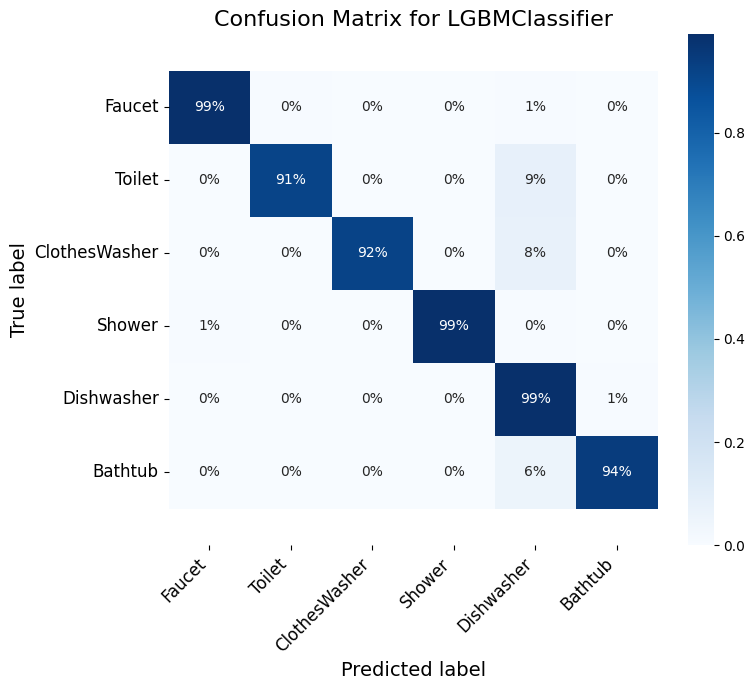

In [13]:
_, ax = get_confusion_matrix(c_test, c_hat, plot=True, labels=categories)
ax.set_title('Confusion Matrix for LGBMClassifier', fontsize=16)
plt.tight_layout()

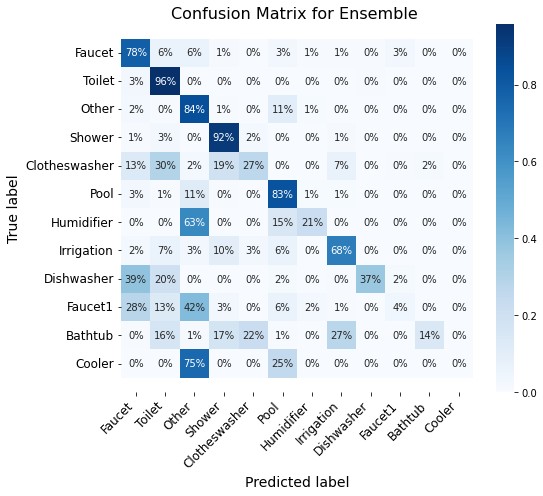

In [ ]:
# confusion matrix of majority vote ensemble
ens_preds = all_tst_preds.max(axis=1)
_, ax = get_confusion_matrix(y_test, ens_preds, plot=True)
ax.set_title('Confusion Matrix for Ensemble ', fontsize=16);
plt.tight_layout()
plt.savefig('/Users/Marie-Philine/Documents/SWN/NIWM/results_w_smote/figures/cm_{}'.format('ensemble'))

In [ ]:
# f1 scores
from sklearn.metrics import f1_score

# store all test results for best models and plot confusion matrices
for algorithm in all_tst_preds.columns:
    print(f"{algorithm}\ttest f1_score={f1_score(y_test, all_tst_preds[algorithm], average='micro'):.3f}".expandtabs(30))
    
print(f"{'Ensemble'}\ttest f1_score={f1_score(y_test, ens_preds, average='micro'):.3f}".expandtabs(30))


ANNClassifier                 test f1_score=0.749
LGBMClassifier                test f1_score=0.859
RandomForestClassifier        test f1_score=0.874
XGBClassifier                 test f1_score=0.891
Ensemble                      test f1_score=0.804
